Hi everyone,

Today you will write your first profit-driven algorithm!

We will start with the hard part, which is creating the profit-driven metric, and the profit-driven algorithm. Afterwards, we will test the performance of this algorithm against some traditional algorithms who do not explicitely account for profitability and demonstrate how this leads to lower expected profitability.

As always, we start by reading in the necessary packages. We will also already create an array which captures the possible values of gamma (acceptance probability). We do this because they remain the same, and calculating this again during every iteration would unnecessarily slow down our computations.

In [1]:
import pandas as pd

basetable = pd.read_csv('./data/dataClassRoomExampleB2Boost.csv')

In [2]:
!pip install xgboost

In [3]:
import numpy as np
import xgboost as xgb
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

beta_dist_s = st.beta.pdf(np.arange(0,1,0.004), 6, 14)
possible_gamma = np.arange(0,1,0.004)
beta_dist_s = beta_dist_s*possible_gamma*0.004

In [4]:
import xgboost as xgb

We will now create our EMPB metric. It takes the arguments `f` (contact cost) and `delta` (incentive rate), which are assumed fixed across the various customers, and the individual predicted churn probabilities (`predictions`), the actually observed churn behavior (`actual`), and the clv estimates (`clv`).

By storing the indices of the customers as ranked by the algorithm (`inds`), we can derive, for each possible contact rate `top_ratio` which customers would be `contacted` and which `clvs` they are estimated to have. For each individual customer `contact`, their individual costs/benefits are calculated based on whether they are false positives or true positives.

The maximal value across each possible contact rate `top_ratio` is stored and returned as `emp`.

In [5]:
def EMPB_validation(predictions, true, clv,  f = 15, delta = 0.0001):
    
    inds = np.flip(predictions.argsort())

    result = []
    for top_ratio in np.arange(0,1,0.005):
        contacted = true[true.index[inds[0:int(round(top_ratio*len(inds)))]]]
        clvs = clv[clv.index[inds[0:int(round(top_ratio*len(inds)))]]]
        emp = 0
        i = 0
        for contact in contacted:
            if contact==1: 
                add = sum(beta_dist_s*((1-delta)*clvs[clvs.index[i]]-f))
                emp += add
            else: 
                add = -f-delta*clvs[clvs.index[i]]
                emp += add
            i += 1    
        result.append(emp)
    emp = np.max(result) 
   
    return(emp)

That was not that hard, right?

So let's now move onto the B2Boost algorithm. This is somewhat trickier. In theory you saw that we recalculated the gradient and the Hessian to do so. But how do we implement this? 

In the [documentation from the xgboost package](https://xgboost.readthedocs.io/en/stable/tutorials/custom_metric_obj.html) you can see that you need to define a loss function (`objecti` in our case) and give this as argument to the `obj` parameter. 

In essence, it is not more difficult than that! Note how we also still have to define our activation function (`predt = 1 / (1 + np.exp(-predt))`) and retrieve the label from our input data (`true = dtrain.get_label()`). Afterwards, we just have to copy the formulas from the theory part!

In [6]:
def b2boost(dtrain: xgb.DMatrix, kBoostRound,gammab2b, lr, clv_train, gamma = 0.3,  f = 15, delta = 0.0001): 
  

    def objecti(predt: np.ndarray,
                    dtrain: xgb.DMatrix):
        predt = 1 / (1 + np.exp(-predt))
        true = dtrain.get_label()
        expected_profits = +f+(delta*clv_train)+true*(clv_train*(-gamma+gamma*delta+delta))
        grad = predt * (1 - predt) * expected_profits
        hess = abs((1 - 2 * predt) * grad)
        return grad, hess

    results = dict()
    model = xgb.train({'tree_method': 'hist', 'seed': 42,
               'disable_default_eval_metric': 1, 'gamma':gammab2b,'learning_rate': lr},
              dtrain=dtrain,
              num_boost_round=kBoostRound,       
              obj=objecti)

    return model

As usual, we will split the data into a training, validation, and test set.

As both churn and clv are important, we will create a stratified sample based on both.

In [7]:
basetable['high_value'] = np.where(basetable['clv']>100000,1,0)
basetable['splitter']  = basetable['high_value'].astype(str) + basetable['churn'].astype(str)
basetable['splitter'].value_counts()

10    4731
00    1479
01    1241
11     332
Name: splitter, dtype: int64

In [8]:
y = basetable['churn']
splitter = basetable['splitter']
x = basetable.drop(columns = ['churn', 'high_value'])

X_trainBig, X_test, y_trainBig, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify = splitter)
splitter2 = X_trainBig['splitter']
X_train, X_val, y_train, y_val = train_test_split(X_trainBig, y_trainBig, test_size=0.25, random_state=42, stratify = splitter2)

clv_train =  X_train['clv']
clv_val =  X_val['clv']
clv_trainBig =  X_trainBig['clv']
clv_test =  X_test['clv']

X_train = X_train.drop(columns = ['clv', 'splitter'])
X_val = X_val.drop(columns = ['clv', 'splitter'])
X_trainBig = X_trainBig.drop(columns = ['clv', 'splitter'])
X_test = X_test.drop(columns = ['clv', 'splitter'])

#Adjust to format required for XGB
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtrainBig = xgb.DMatrix(X_trainBig, label=y_trainBig)
dtest = xgb.DMatrix(X_test, label=y_test)

We will compare B2Boost against its base form (XGBoost) and another highly performant ensemble (random forest).

We manually iterate over all possible hyperparameter values `gammas`, `lrs`, `num_rounds`, and `feat_considered`. Note that the clv values are never feeded to the algorithms during training or prediction, and are only used for evaluation purposes, and are thus implicitely estimated.

In [9]:
import warnings
warnings.filterwarnings('ignore')

gammas = [0.5,1,1.5,2]
lrs = [0.001,0.01,0.1,0.2,0.5]
num_rounds = [2,5,10,20,50,100,200,500]
feat_considered = [2, 4, 6, 8]

print('RF')
waarde = 0
final_num_est = 50 #default value
final_mtry = 6 #default value
for num_est in num_rounds: 
    for mtry in feat_considered:
        rf_model = RandomForestClassifier(n_estimators = num_est, max_features = mtry).fit(X_train, y_train)
        predictions = rf_model.predict_proba(X_val)[:,1]
        waarde2 = EMPB_validation(predictions, y_val, clv_val)
        if waarde2>waarde:                    
            final_num_est = num_est
            final_mtry = mtry
            waarde = waarde2
            print('update')
rf_model = RandomForestClassifier(n_estimators = final_num_est, max_features = final_mtry).fit(X_trainBig, y_trainBig)
predictions = rf_model.predict_proba(X_test)[:,1]    
empb_rf = EMPB_validation(predictions, y_test, clv_test),
auc_rf = roc_auc_score(y_test, predictions)
  
print('B2Boost')
waarde = 0
final_gamma = 1 #default value
final_lr = 0.001#default value
final_rounds = 50 #default value
for gam in gammas:
    for lr in lrs:
        for rounds in num_rounds:
            outcome = b2boost(dtrain, rounds , gam, lr, clv_train)    
            predictions = outcome.predict(dval)
            waarde2 = EMPB_validation(predictions, y_val, clv_val)
            if waarde2>waarde:                    
                final_rounds = rounds
                final_lr = lr
                final_gamma = gam
                waarde = waarde2
                print('update')
b2b = b2boost(dtrainBig, final_rounds , final_gamma, final_lr, clv_trainBig)
predictions = b2b.predict(dtest)
empb_b2b = EMPB_validation(predictions, y_test, clv_test),
auc_b2b = roc_auc_score(y_test, predictions)

print('XGBoost')
waarde = 0
final_gamma = 1 #default value
final_lr = 0.001 #default value
final_rounds = 50 #default value
for gam in gammas:
    for lr in lrs:
        for rounds in num_rounds:
            xgb_model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=rounds, gamma = gam, eta = lr)
            xgb_model.fit(X_train, y_train)
            predictions = xgb_model.predict_proba(X_val)[:,1]
            waarde2 = EMPB_validation(predictions, y_val, clv_val)
            if waarde2>waarde:                     
                final_rounds = rounds
                final_lr = lr
                final_gamma = gam
                waarde = waarde2
                print('update')
xgb_model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=final_rounds, gamma = final_gamma, eta = final_lr)
xgb_model.fit(X_trainBig, y_trainBig)
predictions = xgb_model.predict_proba(X_test)[:,1]
empb_xgb = EMPB_validation(predictions, y_test, clv_test),
auc_xgb = roc_auc_score(y_test, predictions)

RF
update
update
update
update
update
update
update
update
B2Boost
update
update
update
update
update
update
update
update
update
XGBoost
update
update
update
update
update
update
update
update
update
update
update


In [9]:
print(empb_rf)
print(auc_rf)

(8019075.092408966,)
0.8906334069515401


In [10]:
print(empb_b2b)
print(auc_b2b)

(8011927.039868986,)
0.7338996469400618


In [11]:
print(empb_xgb)
print(auc_xgb)

(7776930.944978978,)
0.8905821645802483


In [12]:
predictions_xgb = xgb_model.predict_proba(X_test)[:,1]
empb_xgb3 = EMPB_validation(predictions_xgb, y_test, clv_test, delta = 0.01)
print(empb_xgb3)

predictions_b2b = b2b.predict(dtest)
empb_b2b3 = EMPB_validation(predictions_b2b, y_test, clv_test, delta = 0.01)
print(empb_b2b3)

predictions_rf = rf_model.predict_proba(X_test)[:,1] 
empb_rf3 = EMPB_validation(predictions_rf, y_test, clv_test, delta = 0.01)
print(empb_rf3)

6321277.170899994
5331604.15589999
5830997.421899993


Ok, nice and all, but how does this actually work?

Let us inspect the inner workings of the algorithm. 

To do so, we will first create a new version of our algorithm: `b2boost_visualize`. The major distinction is that we do not only feed an objective function (or at least its gradient and Hessian, but also an evaluation function. Note that this evaluation function is not used in model fitting, it is just used to calculate/visualize intermediate results per iteration.

*Question: Why does our evaluation function differ from the `EMPB_validation` function? Hint: The answer can be found in its name.*

In [13]:
def b2boost_visualize(dtrain: xgb.DMatrix, kBoostRound,gammab2b, lr, clv_train, f = 15, delta = 0.05, gamma = 0.3): 

    def objecti(predt: np.ndarray,
                    dtrain: xgb.DMatrix):
        predt = 1 / (1 + np.exp(-predt))
        true = dtrain.get_label()
        expected_profits =  +f+(delta*clv_train)+true*(clv_train*(-gamma+gamma*delta+delta))  
        grad = predt * (1 - predt) * expected_profits
        hess = abs((1 - 2 * predt) * grad)
        return grad, hess
    
    def deterministic_empb(predt: np.ndarray,
                    dtrain: xgb.DMatrix):
        predt = 1 / (1 + np.exp(-predt))
        true = dtrain.get_label()
        expected_profits = true*(f-gamma*clv_train*(1-delta))+(1-true)*(delta*clv_train+f)
        costs = expected_profits*predt
        return 'DeterministicEMPB', -np.sum(costs)

    results = dict()
    model = xgb.train({'tree_method': 'hist', 'seed': 42,
               'disable_default_eval_metric': 1, 'gamma':gammab2b,'learning_rate': lr},
              feval=deterministic_empb,
              evals=[(dtrain, 'dtrain')],
              evals_result=results,
              dtrain=dtrain,
              num_boost_round=kBoostRound,       
              obj=objecti)

    return model, results

We now deploy this 'new' algorithm with default parameter values.

In [14]:
final_rounds = 100
final_gamma = 1.0
final_lr = 0.1
        
outcome, results = b2boost_visualize(dtrain, final_rounds , final_gamma, final_lr, clv_train)  

[0]	dtrain-DeterministicEMPB:-117439194.07976
[1]	dtrain-DeterministicEMPB:-17220433.70989
[2]	dtrain-DeterministicEMPB:-13013695.80254
[3]	dtrain-DeterministicEMPB:-9822057.52790
[4]	dtrain-DeterministicEMPB:-6982530.77504
[5]	dtrain-DeterministicEMPB:-4496772.97103
[6]	dtrain-DeterministicEMPB:-2216867.58575
[7]	dtrain-DeterministicEMPB:-60604.64225
[8]	dtrain-DeterministicEMPB:1776183.18954
[9]	dtrain-DeterministicEMPB:3556619.66956
[10]	dtrain-DeterministicEMPB:5155596.26227
[11]	dtrain-DeterministicEMPB:6785257.97159
[12]	dtrain-DeterministicEMPB:8080783.69873
[13]	dtrain-DeterministicEMPB:9237222.32066
[14]	dtrain-DeterministicEMPB:10353115.85319
[15]	dtrain-DeterministicEMPB:11307512.45489
[16]	dtrain-DeterministicEMPB:12184837.87329
[17]	dtrain-DeterministicEMPB:12950517.17580
[18]	dtrain-DeterministicEMPB:13642053.25011
[19]	dtrain-DeterministicEMPB:14290208.09292
[20]	dtrain-DeterministicEMPB:14818771.18621
[21]	dtrain-DeterministicEMPB:15305899.66157
[22]	dtrain-Deterministi

The prints already give a good idea about how the algorithm converges. But let us visualize this.

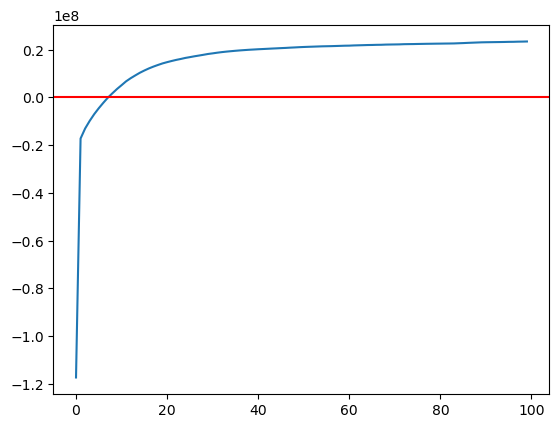

In [15]:
import matplotlib.pyplot as plt

plt.plot(results['dtrain']['DeterministicEMPB'])
plt.axhline(y=0, color='r', linestyle='-')

plt.show()

This plot nicely visualizes how our metric converges. It is clear that the Deterministic EMPB is being optimized, with its (training!) value asymptotically increasing with each iteration. After a couple of iterations EMPB > 0 (red line), which means that at that point, retention campaigns are expected to become profitable. If the blue line could not converge above this value, campaigns are not feasibily profitable! 

Let us compare this with the convergence of the algorithm in terms of AUC.

In [16]:
def b2boost_visualize_other(dtrain: xgb.DMatrix, kBoostRound,gammab2b, lr, clv_train, f = 15, delta = 0.05, gamma = 0.3): 

    def objecti(predt: np.ndarray,
                    dtrain: xgb.DMatrix):
        predt = 1 / (1 + np.exp(-predt))
        true = dtrain.get_label()
        expected_profits =  +f+(delta*clv_train)+true*(clv_train*(-gamma+gamma*delta+delta))  
        grad = predt * (1 - predt) * expected_profits
        hess = abs((1 - 2 * predt) * grad)
        return grad, hess
    
    def auc_eval(predt: np.ndarray,
                    dtrain: xgb.DMatrix):
        predt = 1 / (1 + np.exp(-predt))
        true = dtrain.get_label()
        score = roc_auc_score(true, predt)
        return 'ROC_AUC', score

    results = dict()
    model = xgb.train({'tree_method': 'hist', 'seed': 42,
               'disable_default_eval_metric': 1, 'gamma':gammab2b,'learning_rate': lr}, 
              feval=auc_eval,
              evals=[(dtrain, 'dtrain')],
              evals_result=results,
              dtrain=dtrain,
              num_boost_round=kBoostRound,       
              obj=objecti)

    return model, results

In [17]:
outcome2, results2 = b2boost_visualize_other(dtrain, final_rounds , final_gamma, final_lr, clv_train)  

[0]	dtrain-ROC_AUC:0.88096
[1]	dtrain-ROC_AUC:0.88961
[2]	dtrain-ROC_AUC:0.90329
[3]	dtrain-ROC_AUC:0.90181
[4]	dtrain-ROC_AUC:0.90340
[5]	dtrain-ROC_AUC:0.90360
[6]	dtrain-ROC_AUC:0.90502
[7]	dtrain-ROC_AUC:0.90923
[8]	dtrain-ROC_AUC:0.91003
[9]	dtrain-ROC_AUC:0.91228
[10]	dtrain-ROC_AUC:0.91372
[11]	dtrain-ROC_AUC:0.91778
[12]	dtrain-ROC_AUC:0.91887
[13]	dtrain-ROC_AUC:0.91999
[14]	dtrain-ROC_AUC:0.92097
[15]	dtrain-ROC_AUC:0.92193
[16]	dtrain-ROC_AUC:0.92350
[17]	dtrain-ROC_AUC:0.92468
[18]	dtrain-ROC_AUC:0.92543
[19]	dtrain-ROC_AUC:0.92649
[20]	dtrain-ROC_AUC:0.92768
[21]	dtrain-ROC_AUC:0.92778
[22]	dtrain-ROC_AUC:0.92841
[23]	dtrain-ROC_AUC:0.92917
[24]	dtrain-ROC_AUC:0.93105
[25]	dtrain-ROC_AUC:0.93196
[26]	dtrain-ROC_AUC:0.93316
[27]	dtrain-ROC_AUC:0.93423
[28]	dtrain-ROC_AUC:0.93454
[29]	dtrain-ROC_AUC:0.93564
[30]	dtrain-ROC_AUC:0.93644
[31]	dtrain-ROC_AUC:0.93724
[32]	dtrain-ROC_AUC:0.93760
[33]	dtrain-ROC_AUC:0.93864
[34]	dtrain-ROC_AUC:0.93936
[35]	dtrain-ROC_AUC:0.93967
[3

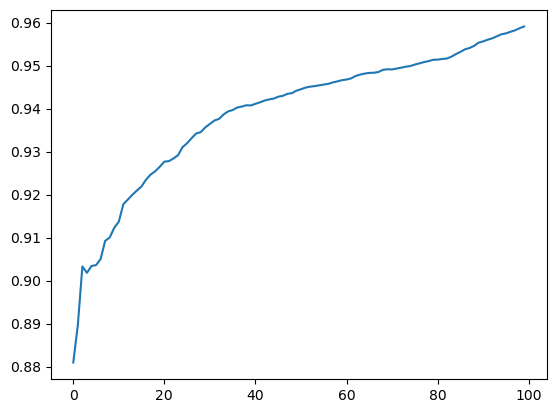

In [18]:
import matplotlib.pyplot as plt

plt.plot(results2['dtrain']['ROC_AUC'])
plt.show()

The training AUC also generally increases but it does not show the same typical asymptotic convergence pattern, with even some downwards sloping bumps. 